## Imports

https://www.kaggle.com/mlg-ulb/creditcardfraud

In [81]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import imblearn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, confusion_matrix, f1_score, accuracy_score, average_precision_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import plot_precision_recall_curve
import keras
import tensorflow_addons as tfa
import keras.backend as K
from tqdm import tqdm
plt.style.use("seaborn")

In [82]:
records = pd.read_csv('creditcard.csv', delimiter=',', header=0)

# Check if data is well-formed

## Distribution of fraudulent vs. good transactions
Very few fraudulent records

In [83]:
records.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

## Normalize data

In [84]:
#Mean normalization
targets = records.pop('Class')
normalized_records=(records-records.mean())/records.std()
#normalized_records.hist(figsize=(20,20));

## Compare hists between classes

In [85]:
records0 = normalized_records[targets==0]
records1 = normalized_records[targets==1]
#records0.hist(figsize=(20,20));

In [86]:
# print("Differences between fraud and non-fraud:")
# for i in records0.keys():
#     print("Differences in",i)
#     print("Median:", records0[i].median()-records1[i].median())
#     print("Mean:", records0[i].mean()-records1[i].mean())
#     print("Std:", records0[i].std()-records1[i].std())
    
#     print()

Differences between fraud and non-fraud:
Differences in Time
Median: 0.19252172971223316
Mean: 0.2967350075315986
Std: -0.007398674870575661

Differences in V1
Median: 1.2061703137691455
Mean: 2.4405046304538205
Std: -2.4781146185470924

Differences in V2
Median: -1.6070883853499391
Mean: -2.198286258857717
Std: -1.6078579173914733

Differences in V3
Median: 3.4673686501116703
Mean: 4.64661415234859
Std: -3.727280862082994

Differences in V4
Median: -2.966060774701858
Mean: -3.2134966851943867
Std: -1.041046096449672

Differences in V5
Median: 1.0646680521499936
Mean: 2.2870389213706708
Std: -2.9092742802983906

Differences in V6
Median: 0.8643081611514458
Mean: 1.050953871019782
Std: -0.3964738063666099

Differences in V7
Median: 2.4861012371395548
Mean: 4.509252688613915
Std: -4.872679520684369

Differences in V8
Median: -0.5019178436083024
Mean: -0.4786050799310731
Std: -4.719331507786939

Differences in V9
Median: 1.9649929610563892
Mean: 2.3534625610834463
Std: -1.2848010599682733

In [88]:
top10 = ['V3', 'V4', 'V7', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18'] #Based on largest difference in median.
top10_perm = ['V14','V12','V17','V10','V4','V16','V7','V2','V11','Amount']
X_median = normalized_records[top10].to_numpy()
y = targets.to_numpy()

X_perm = normalized_records[top10_perm].to_numpy()
X_all = normalized_records.to_numpy()

### Performance Metrics
The function below calculates a series of performance metrics.
1. Accuracy - This is the default metric and is not suited for this problem.
2. False negatives, False positives, True positives - Gives insight in how it classifies.
3. F1 score - Is considered suited for imbalanced datasets.
4. AUPRC - Area Under Precision-Recall Curve is the suggested metric from Kaggle.
5. AUC ROC - Area Under Curve Receiving Operating Characteristic is widely used for this specific task, but not good for imbalanced datasets
6. Average Precision - Should be a good overall measure for this task. 
7. Mean score for metrics - The mean for 3, 4, 5, 6

In [141]:
#True negatives are not printed due to it being the default classification.
def evaluate_model(model, name="", verbose=False, dataset=(X_all_smote, X_all_test, y_all_smote, y_all_test)):
    _, X_test, _, y_test = dataset
    preds = model.predict(X_test)
    preds_proba = model.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, preds_proba)
    fpr, tpr, _ = roc_curve(y_test, preds_proba)
    f1 = f1_score(preds, y_test)
    aucroc = auc(fpr, tpr)
    auprc = auc(recall, precision)
    avg_precision = average_precision_score(y_test, preds_proba)
    mean_score = np.mean([f1, auprc, aucroc, avg_precision])
    
    if verbose:
        cm = confusion_matrix(preds, y_test)
        tn, fp, fn, tp = cm.ravel()
        
        print("{} performance metrics:\n-=-=-=-=-=-".format(name))
        print("Raw accuracy (bad metric):", accuracy_score(preds, y_test))
        print("False negatives:", fn)
        print("False positives:", fp)
        print("True positives:", tp)
        print("F1 score:", f1)

        print("AUPRC:", auprc)
        print("AUC ROC:", aucroc)
        print("Average Precision Score:", avg_precision)
        print("Mean Score for Metrics:", mean_score)
        print()
    
    return [f1, auprc, aucroc, avg_precision, mean_score]

def print_scores(scores, name=""):
    print("{} performance metrics:\n-=-=-=-=-=-".format(name))
    print("F1 score:", scores[0])
    print("AUPRC:", scores[1])
    print("AUC ROC:", scores[2])
    print("Average Precision Score:", scores[3])
    print("Mean Score for Metrics:", scores[4])
    print()

def AUC_PR(preds_proba, y):
    precision, recall, _ = precision_recall_curve(y, preds_proba)
    auprc = auc(recall, precision)
    return auprc

def preds_to_auprc(pred_dict):
    if pred_dict['all'].shape[1]>1:
        pred_dict['all'] = pred_dict['all'][:,1]
        pred_dict['median'] = pred_dict['median'][:,1]
        pred_dict['perm'] = pred_dict['perm'][:,1]
    
    all_auc = AUC_PR(pred_dict['all'], y_all_test)
    med_auc = AUC_PR(pred_dict['median'], y_median_test)
    perm_auc = AUC_PR(pred_dict['perm'], y_perm_test)
    return all_auc, med_auc, perm_auc

## Evaluation
Using Stratified K-fold and the metrics above

In [90]:
oversample = imblearn.over_sampling.SMOTE()

#All dataset
X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(X_all, y, random_state=42)
X_all_smote, y_all_smote = oversample.fit_resample(X_all_train, y_all_train)

#Top 10 median dataset
X_median_train, X_median_test, y_median_train, y_median_test = train_test_split(X_median, y, random_state=42)
X_median_smote, y_median_smote = oversample.fit_resample(X_median_train, y_median_train)

#Top 10 perm dataset
X_perm_train, X_perm_test, y_perm_train, y_perm_test = train_test_split(X_perm, y, random_state=42)
X_perm_smote, y_perm_smote = oversample.fit_resample(X_perm_train, y_median_train)

In [120]:
skf = StratifiedKFold(n_splits=5)
lrg = LogisticRegression(n_jobs=4, random_state=42)
knn = KNeighborsClassifier(n_jobs=4)
rfc = RandomForestClassifier(n_estimators=300, n_jobs=4, random_state=42)
nbc = GaussianNB()
mlp = MLPClassifier(hidden_layer_sizes=[1000,200], random_state=42) #1000 500
dum = DummyClassifier(random_state=42)


def cross_val_train_model(model, name="", dataset=(X_all_smote, X_all_test, y_all_smote, y_all_test)):
    X_train, X_test, y_train, y_test = dataset 
    
    accuracies = []
    for train_index, valid_index in tqdm(skf.split(X_train,y_train)):
        X_strat_train, X_valid = X_train[train_index], X_train[valid_index]
        y_strat_train, y_valid = y_train[train_index], y_train[valid_index]

        model.fit(X_strat_train, y_strat_train)
        accuracies.append(evaluate_model(model, dataset=dataset))

    print_scores(np.mean(accuracies, axis=0), name=name)

def model_prediction(model, dataset=(X_all_smote, X_all_test, y_all_smote, y_all_test)):
    X_train, X_test, y_train, y_test = dataset
    model.fit(X_train, y_train)
    return model.predict_proba(X_test)

In [110]:
#cross_val_train_model(dum, name="Baseline", dataset=(X_median_smote, X_median_test, y_median_smote, y_median_test))
# cross_val_train_model(lrg, name="Logistic Regression")
# cross_val_train_model(knn, name="K-Nearest neighbours")
# cross_val_train_model(rfc, name="Random Forest")
# cross_val_train_model(nb, name="Naive Bayes")
# cross_val_train_model(mlp, name="Multilayer Perceptron")

In [121]:
def train_on_all_sets(model, name=""):
    #Function does 5-fold cross validation and returns predictions on test set. 
    datasets = {
        'all' : (X_all_smote, X_all_test, y_all_smote, y_all_test),
        'median' : (X_median_smote, X_median_test, y_median_smote, y_median_test),
        'perm' : (X_perm_smote, X_perm_test, y_perm_smote, y_perm_test)
    }
    preds = {
        'all' : None,
        'median' : None,
        'perm' : None
    }
    for dataset in datasets:
        cross_val_train_model(model, name="{}_{}".format(name, dataset), dataset=datasets[dataset])
        preds[dataset] = model_prediction(model, dataset=datasets[dataset])
    
    return preds

In [122]:
dum_preds = train_on_all_sets(dum, name="Baseline")
lrg_preds = train_on_all_sets(lrg, name="Logistic Regression")
mlp_preds = train_on_all_sets(mlp, name="Multilayer Perceptron")
rfc_preds = train_on_all_sets(rfc, name="Random Forest")
nbc_preds = train_on_all_sets(nbc, name="Naive Bayes")

5it [00:00,  7.38it/s]
1it [00:00,  7.77it/s]

Baseline_all performance metrics:
-=-=-=-=-=-
F1 score: 0.0006338077543293836
AUPRC: 0.5007935170360384
AUC ROC: 0.5
Average Precision Score: 0.001587034072076627
Mean Score for Metrics: 0.2507535897156111



5it [00:00,  9.44it/s]
1it [00:00,  6.31it/s]

Baseline_median performance metrics:
-=-=-=-=-=-
F1 score: 0.0006338077543293836
AUPRC: 0.5007935170360384
AUC ROC: 0.5
Average Precision Score: 0.001587034072076627
Mean Score for Metrics: 0.2507535897156111



5it [00:00,  9.18it/s]
0it [00:00, ?it/s]

Baseline_perm performance metrics:
-=-=-=-=-=-
F1 score: 0.0006338077543293836
AUPRC: 0.5007935170360384
AUC ROC: 0.5
Average Precision Score: 0.001587034072076627
Mean Score for Metrics: 0.2507535897156111



5it [01:14, 14.93s/it]


Logistic Regression_all performance metrics:
-=-=-=-=-=-
F1 score: 0.10145712853414586
AUPRC: 0.7641884147257637
AUC ROC: 0.9776063209809166
Average Precision Score: 0.7241036401982139
Mean Score for Metrics: 0.64183887610976



5it [00:07,  1.57s/it]


Logistic Regression_median performance metrics:
-=-=-=-=-=-
F1 score: 0.09928810532391544
AUPRC: 0.7346279747515722
AUC ROC: 0.9769084422032608
Average Precision Score: 0.727644421336276
Mean Score for Metrics: 0.6346172359037561



5it [00:08,  1.66s/it]


Logistic Regression_perm performance metrics:
-=-=-=-=-=-
F1 score: 0.09865114295269871
AUPRC: 0.7333503805288295
AUC ROC: 0.9766535454684313
Average Precision Score: 0.7345513215728412
Mean Score for Metrics: 0.6358015976307002



5it [2:35:14, 1862.98s/it]


Multilayer Perceptron_all performance metrics:
-=-=-=-=-=-
F1 score: 0.7555006493936492
AUPRC: 0.8172491603410876
AUC ROC: 0.9640903954745996
Average Precision Score: 0.8167369749950024
Mean Score for Metrics: 0.8383942950510848



5it [4:13:22, 3040.43s/it]


Multilayer Perceptron_median performance metrics:
-=-=-=-=-=-
F1 score: 0.6323557182221127
AUPRC: 0.759904686870822
AUC ROC: 0.9663066999275619
Average Precision Score: 0.7608573403873474
Mean Score for Metrics: 0.779856111351961



5it [4:24:37, 3175.57s/it]


Multilayer Perceptron_perm performance metrics:
-=-=-=-=-=-
F1 score: 0.5862709508954747
AUPRC: 0.764449848078811
AUC ROC: 0.9647102217748487
Average Precision Score: 0.7651221344686394
Mean Score for Metrics: 0.7701382888044435



5it [16:35, 199.10s/it]


Random Forest_all performance metrics:
-=-=-=-=-=-
F1 score: 0.8372169606001189
AUPRC: 0.8708098694420794
AUC ROC: 0.9868222023072908
Average Precision Score: 0.8701309380323426
Mean Score for Metrics: 0.891244992595458



5it [10:05, 121.12s/it]


Random Forest_median performance metrics:
-=-=-=-=-=-
F1 score: 0.7598569948965721
AUPRC: 0.8393757932716012
AUC ROC: 0.9787847266613445
Average Precision Score: 0.8290123910797108
Mean Score for Metrics: 0.8517574764773072



5it [09:46, 117.28s/it]


Random Forest_perm performance metrics:
-=-=-=-=-=-
F1 score: 0.7698672565382448
AUPRC: 0.8357502390738146
AUC ROC: 0.9681135214153217
Average Precision Score: 0.828446364625367
Mean Score for Metrics: 0.8505443454131871



5it [00:02,  2.49it/s]


Naive Bayes_all performance metrics:
-=-=-=-=-=-
F1 score: 0.10681756340680408
AUPRC: 0.4216006769214535
AUC ROC: 0.9631797458925039
Average Precision Score: 0.0841053674639757
Mean Score for Metrics: 0.39392583842118434



5it [00:00,  5.15it/s]
0it [00:00, ?it/s]

Naive Bayes_median performance metrics:
-=-=-=-=-=-
F1 score: 0.15846482064283995
AUPRC: 0.5279829549350588
AUC ROC: 0.9627679474949573
Average Precision Score: 0.25389319222480017
Mean Score for Metrics: 0.4757772288244141



5it [00:00,  5.18it/s]

Naive Bayes_perm performance metrics:
-=-=-=-=-=-
F1 score: 0.14484572266089396
AUPRC: 0.5077910860463386
AUC ROC: 0.9586160411907946
Average Precision Score: 0.2401902264281462
Mean Score for Metrics: 0.4628607690815433



0it [00:00, ?it/s]

Epoch 1/1000
8529/8529 [==============================] - 17s 2ms/step - loss: 0.1845 - prc: 0.9797 - val_loss: 0.1305 - val_prc: 0.9903
Epoch 2/1000
8529/8529 [==============================] - 14s 2ms/step - loss: 0.1434 - prc: 0.9874 - val_loss: 0.1050 - val_prc: 0.9943
Epoch 3/1000
8529/8529 [==============================] - 15s 2ms/step - loss: 0.1307 - prc: 0.9897 - val_loss: 0.0880 - val_prc: 0.9963
Epoch 4/1000
8529/8529 [==============================] - 14s 2ms/step - loss: 0.1226 - prc: 0.9910 - val_loss: 0.0799 - val_prc: 0.9967
Epoch 5/1000
8529/8529 [==============================] - 14s 2ms/step - loss: 0.1163 - prc: 0.9919 - val_loss: 0.0723 - val_prc: 0.9975
Epoch 6/1000
8529/8529 [==============================] - 14s 2ms/step - loss: 0.1095 - prc: 0.9928 - val_loss: 0.0662 - val_prc: 0.9979
Epoch 7/1000
8529/8529 [==============================] - 14s 2ms/step - loss: 0.1074 - prc: 0.9931 - val_loss: 0.0615 - val_prc: 0.9981
Epoch 8/1000
8529/8529 [=================

1it [07:59, 479.03s/it]

Epoch 1/1000
8529/8529 [==============================] - 14s 2ms/step - loss: 0.1836 - prc: 0.9798 - val_loss: 0.1277 - val_prc: 0.9906
Epoch 2/1000
8529/8529 [==============================] - 14s 2ms/step - loss: 0.1426 - prc: 0.9876 - val_loss: 0.1035 - val_prc: 0.9941
Epoch 3/1000
8529/8529 [==============================] - 14s 2ms/step - loss: 0.1288 - prc: 0.9900 - val_loss: 0.0907 - val_prc: 0.9956
Epoch 4/1000
8529/8529 [==============================] - 14s 2ms/step - loss: 0.1197 - prc: 0.9914 - val_loss: 0.0804 - val_prc: 0.9965
Epoch 5/1000
8529/8529 [==============================] - 14s 2ms/step - loss: 0.1134 - prc: 0.9923 - val_loss: 0.0712 - val_prc: 0.9974
Epoch 6/1000
8529/8529 [==============================] - 14s 2ms/step - loss: 0.1078 - prc: 0.9930 - val_loss: 0.0655 - val_prc: 0.9978
Epoch 7/1000
8529/8529 [==============================] - 14s 2ms/step - loss: 0.1045 - prc: 0.9934 - val_loss: 0.0595 - val_prc: 0.9982
Epoch 8/1000
8529/8529 [=================

2it [13:19, 431.58s/it]

Epoch 1/1000
8529/8529 [==============================] - 15s 2ms/step - loss: 0.1806 - prc: 0.9804 - val_loss: 0.1220 - val_prc: 0.9917
Epoch 2/1000
8529/8529 [==============================] - 13s 2ms/step - loss: 0.1420 - prc: 0.9878 - val_loss: 0.1011 - val_prc: 0.9947
Epoch 3/1000
8529/8529 [==============================] - 14s 2ms/step - loss: 0.1298 - prc: 0.9898 - val_loss: 0.0873 - val_prc: 0.9961
Epoch 4/1000
8529/8529 [==============================] - 14s 2ms/step - loss: 0.1205 - prc: 0.9914 - val_loss: 0.0798 - val_prc: 0.9966
Epoch 5/1000
8529/8529 [==============================] - 14s 2ms/step - loss: 0.1134 - prc: 0.9923 - val_loss: 0.0709 - val_prc: 0.9974
Epoch 6/1000
8529/8529 [==============================] - 14s 2ms/step - loss: 0.1092 - prc: 0.9929 - val_loss: 0.0655 - val_prc: 0.9977
Epoch 7/1000
8529/8529 [==============================] - 13s 2ms/step - loss: 0.1057 - prc: 0.9934 - val_loss: 0.0614 - val_prc: 0.9983
Epoch 8/1000
8529/8529 [=================

3it [22:17, 463.39s/it]

Epoch 1/1000
8529/8529 [==============================] - 14s 2ms/step - loss: 0.1844 - prc: 0.9797 - val_loss: 0.1289 - val_prc: 0.9906
Epoch 2/1000
8529/8529 [==============================] - 14s 2ms/step - loss: 0.1443 - prc: 0.9874 - val_loss: 0.1031 - val_prc: 0.9945
Epoch 3/1000
8529/8529 [==============================] - 14s 2ms/step - loss: 0.1315 - prc: 0.9896 - val_loss: 0.0893 - val_prc: 0.9958
Epoch 4/1000
8529/8529 [==============================] - 14s 2ms/step - loss: 0.1228 - prc: 0.9909 - val_loss: 0.0787 - val_prc: 0.9967
Epoch 5/1000
8529/8529 [==============================] - 14s 2ms/step - loss: 0.1173 - prc: 0.9917 - val_loss: 0.0726 - val_prc: 0.9975
Epoch 6/1000
8529/8529 [==============================] - 14s 2ms/step - loss: 0.1103 - prc: 0.9927 - val_loss: 0.0652 - val_prc: 0.9977
Epoch 7/1000
8529/8529 [==============================] - 14s 2ms/step - loss: 0.1061 - prc: 0.9933 - val_loss: 0.0596 - val_prc: 0.9982
Epoch 8/1000
8529/8529 [=================

4it [30:52, 478.74s/it]

Epoch 1/1000
8529/8529 [==============================] - 14s 2ms/step - loss: 0.1822 - prc: 0.9801 - val_loss: 0.1294 - val_prc: 0.9911
Epoch 2/1000
8529/8529 [==============================] - 13s 2ms/step - loss: 0.1431 - prc: 0.9876 - val_loss: 0.1013 - val_prc: 0.9943
Epoch 3/1000
8529/8529 [==============================] - 14s 2ms/step - loss: 0.1295 - prc: 0.9898 - val_loss: 0.0891 - val_prc: 0.9960
Epoch 4/1000
8529/8529 [==============================] - 14s 2ms/step - loss: 0.1212 - prc: 0.9912 - val_loss: 0.0791 - val_prc: 0.9967
Epoch 5/1000
8529/8529 [==============================] - 14s 2ms/step - loss: 0.1139 - prc: 0.9922 - val_loss: 0.0715 - val_prc: 0.9974
Epoch 6/1000
8529/8529 [==============================] - 14s 2ms/step - loss: 0.1105 - prc: 0.9928 - val_loss: 0.0665 - val_prc: 0.9977
Epoch 7/1000
8529/8529 [==============================] - 14s 2ms/step - loss: 0.1060 - prc: 0.9933 - val_loss: 0.0616 - val_prc: 0.9981
Epoch 8/1000
8529/8529 [=================

5it [41:11, 494.20s/it]

Wall time: 41min 11s


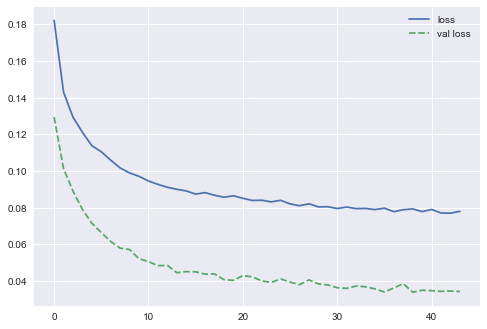

In [58]:
%%time
focal_loss = tfa.losses.SigmoidFocalCrossEntropy(alpha=1, gamma=10)
epochs_ = 1000
batch_size_ = 25
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(X_all, y, random_state=42)
# X_all_smote, y_all_smote = oversample.fit_resample(X_all_train, y_all_train)

# #Top 10 median dataset
# X_median_train, X_median_test, y_median_train, y_median_test = train_test_split(X_median, y, random_state=42)
# X_median_smote, y_median_smote = oversample.fit_resample(X_median_train, y_median_train)

# #Top 10 perm dataset
# X_perm_train, X_perm_test, y_perm_train, y_perm_test = train_test_split(X_perm, y, random_state=42)
# X_perm_smote, y_perm_smote = oversample.fit_resample(X_perm_train, y_median_train)

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

datasets = {
    'all' : (X_all_smote, X_all_test, y_all_smote, y_all_test),
    'median' : (X_median_smote, X_median_test, y_median_smote, y_median_test),
    'perm' : (X_perm_smote, X_perm_test, y_perm_smote, y_perm_test)
}
nn_preds = {
    'all' : None,
    'median' : None,
    'perm' : None
}
for dataset in datasets:
    temp_X, temp_y = datasets[dataset][0], datasets[dataset][2]
    temp_X_test, temp_y_test = datasets[dataset][1], datasets[dataset][3]
    accuracies = []
    histories = []
    for train_index, valid_index in tqdm(skf.split(temp_X, temp_y)):
        X_strat_train, X_validation = temp_X[train_index], temp_X[valid_index]
        y_strat_train, y_validation = temp_y[train_index], temp_y[valid_index]

        nn = keras.Sequential([
            keras.layers.BatchNormalization(),
            keras.layers.Dense(256, activation="relu"),
            keras.layers.Dropout(0.4),
            keras.layers.Dense(128, activation='relu'),
            keras.layers.Dropout(0.4),
            keras.layers.Dense(64, activation='relu'),
            keras.layers.Dense(1, activation="sigmoid"),
        ])


        nn.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), #'binary_crossentropy'
                   loss='binary_crossentropy',
                   metrics=[keras.metrics.AUC(name='prc', curve='PR')])

        history = nn.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=epochs_, 
                         batch_size=batch_size_, callbacks=[callback])
        histories.append(history)
        accuracies.append(AUC_PR(nn.predict(temp_X_test), temp_y_test))
    
    nn_preds[dataset] = nn.predict(temp_X_test)
    
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], '--', label="val loss")
plt.legend()

In [73]:
losses = [np.array(x.history['loss']) for x in histories]

In [78]:
np.mean(accuracies)

0.7521233862758236

Text(0.5, 1.0, 'Binary Crossentropy loss')

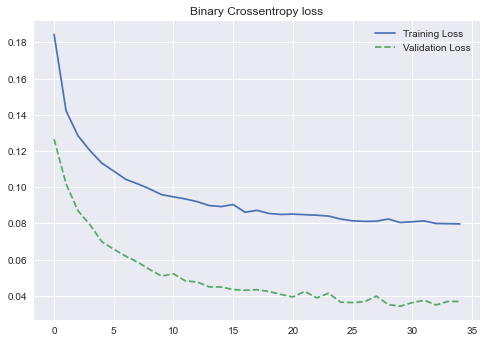

In [45]:
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], '--', label="Validation Loss")
plt.legend()
plt.title("Binary Crossentropy loss")

0.7705095177815201

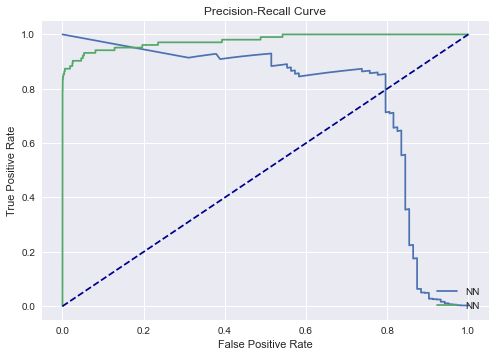

In [55]:
create_pr_curve(nn.predict(X_test), y_test, label="NN", title="Precision-Recall Curve")
create_roc_curve(nn.predict(X_test), y_test, label="NN", title="Precision-Recall Curve")
AUC_PR(nn.predict(X_test))

### Saving Results

In [126]:
#Copied this function from a previous project, hence the misleading name.
import pickle
def save_features(feature_dict, filename='features'):
    '''Save the updated feature dictionary. Takes dictionary as input and saves as binary file
    
    example: 
    >>> my_featues = {'freqdist': [1,6,3,5]}
    >>> save_features(my_features)'''
    
    with open('data/{}.dat'.format(filename), 'wb') as file:
        pickle.dump(feature_dict, file)
    print("Features saved! :-)")

def load_features(filename='features'):
    '''Load feature dictionary. Returns the saved feature as a dictionary.
    
    example: 
    >>> my_features = load_features()'''
    
    with open('data/{}.dat'.format(filename), 'rb') as file:
        feats = pickle.load(file)
    print("Features available:")
    
    if type(feats) != dict:
        return feats
    for i in feats.keys():
        print(i)
    return feats

In [127]:
model_predictions = {
    'dum' : dum_preds,
    'lrg' : lrg_preds,
    'mlp' : mlp_preds,
    'rfc' : rfc_preds,
    'nbc' : nbc_preds,
}
save_features(model_predictions, filename="sklearn_predictions")

Features saved! :-)


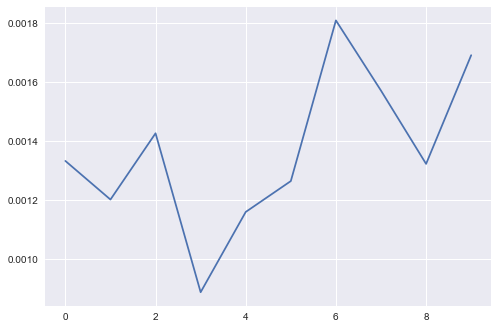

In [149]:
plt.plot(history.history['val_loss'], label="val loss")

In [122]:
mlp.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': [1000, 200],
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 42,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [119]:
evaluate_model(lrg, verbose=True)

 performance metrics:
-=-=-=-=-=-
Raw accuracy (bad metric): 0.9989887924496503
False negatives: 21
False positives: 51
True positives: 60
F1 score: 0.625
AUPRC: 0.660891641643524
AUC ROC: 0.9598326013062055
Average Precision Score: 0.6622137705085297
Mean Score for Metrics: 0.7269845033645649



[0.625,
 0.660891641643524,
 0.9598326013062055,
 0.6622137705085297,
 0.7269845033645649]

In [176]:
def plot_roc_cur(fper, tper, label="", line="", title="plot title"):
    plt.plot(fper, tper, line, label=label)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    
def create_roc_curve(preds, targets, label="", line="", title=""):
    all_fpr, all_tpr = [], []
    fpr, tpr, thresholds = roc_curve(targets, preds)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_fpr = np.array(all_fpr)
    all_tpr = np.array(tpr)
    
    plot_roc_cur(all_fpr[0], all_tpr, label=label, line=line, title=title)

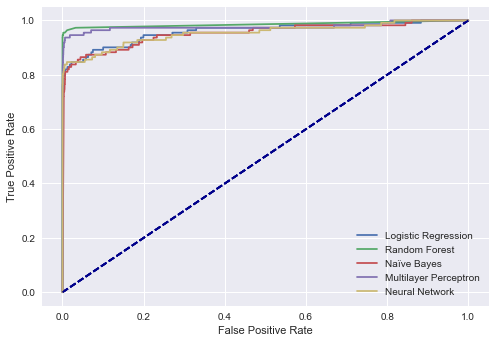

In [175]:
create_roc_curve(lrg.predict_proba(X_test)[:,1], y_test, label="Logistic Regression")
#create_roc_curve(svc.predict_proba(X_test)[:,1], y_test, label="Support Vector Classifier")
create_roc_curve(rfc.predict_proba(X_test)[:,1], y_test, label="Random Forest")
create_roc_curve(nb.predict_proba(X_test)[:,1], y_test, label="Naïve Bayes")
create_roc_curve(mlp.predict_proba(X_test)[:,1], y_test, label="Multilayer Perceptron")
create_roc_curve(nn.predict(X_test), y_test, label="Neural Network")

## Precicion Recall Curve

In [153]:
def plot_pr_cur(p, r, label="", line="", title="plot title"):
    plt.plot(r, p, line, label=label)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc='best')
    
def create_pr_curve(preds, targets, label="", line="", title=""):
    all_p, all_r = [], []
    p, r, thresholds = precision_recall_curve(targets, preds)
    all_p.append(p)
    all_r.append(r)
    all_p = np.array(p)
    all_r = np.array(r)
    
    plot_pr_cur(all_p, all_r, label=label, title=title, line=line)

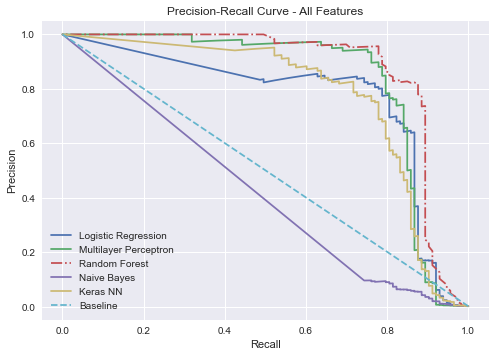

In [172]:
create_pr_curve(lrg_preds['all'], y_all_test, label="Logistic Regression")
create_pr_curve(mlp_preds['all'][:,1], y_all_test, label="Multilayer Perceptron")
create_pr_curve(rfc_preds['all'], y_all_test, line='-.', label="Random Forest")
create_pr_curve(nbc_preds['all'][:,1], y_all_test, label="Naive Bayes")
create_pr_curve(nn_preds['all'], y_all_test, label="Keras NN")
create_pr_curve(dum_preds['all'], y_all_test, label="Baseline", line='--', title="Precision-Recall Curve - All Features")

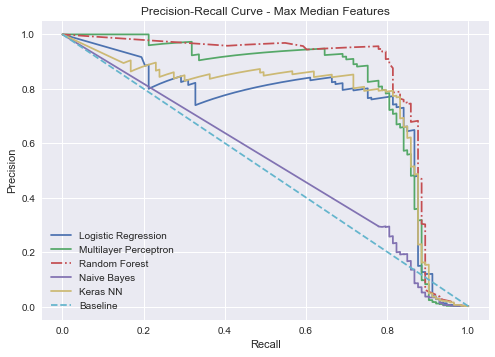

In [175]:
create_pr_curve(lrg_preds['median'], y_median_test, label="Logistic Regression")
create_pr_curve(mlp_preds['median'][:,1], y_median_test, label="Multilayer Perceptron")
create_pr_curve(rfc_preds['median'], y_median_test, line='-.', label="Random Forest")
create_pr_curve(nbc_preds['median'][:,1], y_median_test, label="Naive Bayes")
create_pr_curve(nn_preds['median'], y_median_test, label="Keras NN")
create_pr_curve(dum_preds['median'], y_median_test, label="Baseline", line='--', title="Precision-Recall Curve - Max Median Features")

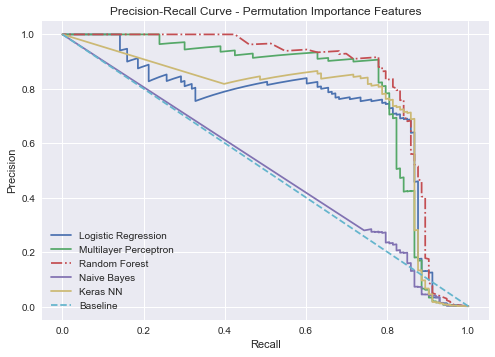

In [173]:
create_pr_curve(lrg_preds['perm'], y_perm_test, label="Logistic Regression")
create_pr_curve(mlp_preds['perm'][:,1], y_perm_test, label="Multilayer Perceptron")
create_pr_curve(rfc_preds['perm'], y_perm_test, line='-.', label="Random Forest")
create_pr_curve(nbc_preds['perm'][:,1], y_perm_test, label="Naive Bayes")
create_pr_curve(nn_preds['perm'], y_perm_test, label="Keras NN")
create_pr_curve(dum_preds['perm'], y_perm_test, label="Baseline", line='--', title="Precision-Recall Curve - Permutation Importance Features")

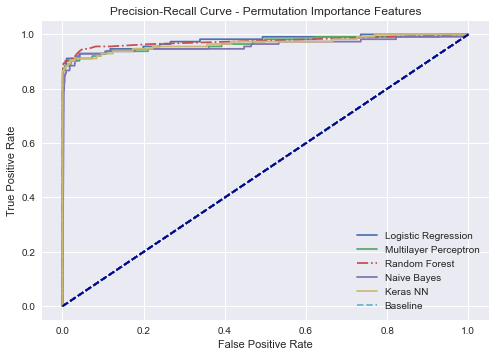

In [177]:
create_roc_curve(lrg_preds['perm'], y_perm_test, label="Logistic Regression")
create_roc_curve(mlp_preds['perm'][:,1], y_perm_test, label="Multilayer Perceptron")
create_roc_curve(rfc_preds['perm'], y_perm_test, line='-.', label="Random Forest")
create_roc_curve(nbc_preds['perm'][:,1], y_perm_test, label="Naive Bayes")
create_roc_curve(nn_preds['perm'], y_perm_test, label="Keras NN")
create_roc_curve(dum_preds['perm'], y_perm_test, label="Baseline", line='--', title="Precision-Recall Curve - Permutation Importance Features")

In [128]:
nn_preds = load_features(filename="nn_preds")

Features available:
all
median
perm


In [138]:
preds_to_auprc(nn_preds)

(0.7764051352769953, 0.752327022162884, 0.7544125038624634)

In [144]:
preds_to_auprc(rfc_preds)

(0.8742866290724697, 0.8424790452654549, 0.8430935450767226)

In [140]:
nn_preds['all'].shape

(71202, 1)